# How much chemistry to be useful?
> A tutorial of fastpages for Jupyter notebooks.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/post1_chemception_input.png

# About

This notebook is a demonstration of some of capabilities of [fastpages](https://github.com/fastai/fastpages) with notebooks.


With `fastpages` you can save your jupyter notebooks into the `_notebooks` folder at the root of your repository, and they will be automatically be converted to Jekyll compliant blog posts!


## Front Matter

The first cell in your Jupyter Notebook or markdown blog post contains front matter. Front matter is metadata that can turn on/off options in your Notebook. It is formatted like this:

```
# "My Title"
> "Awesome summary"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Hamel Husain & Jeremy Howard
- categories: [fastpages, jupyter]
```

- Setting `toc: true` will automatically generate a table of contents
- Setting `badges: true` will automatically include GitHub and Google Colab links to your notebook.
- Setting `comments: true` will enable commenting on your blog post, powered by [utterances](https://github.com/utterance/utterances).

The title and description need to be enclosed in double quotes only if they include special characters such as a colon. More details and options for front matter can be viewed on the [front matter section](https://github.com/fastai/fastpages#front-matter-related-options) of the README.

In [ ]:
#!conda install -c rdkit rdkit Install rdkit before running this

In [1]:
#collapse-show
from rdkit.Chem import MolFromSmiles, MolToSmiles
from fastai.vision.all import *
from rdkit.Chem import AllChem
from rdkit import Chem
import numpy as np
import pandas as pd
import IPython.display
from PIL import Image

Hi! This is will be the first post from my new blog. I hope you guys enjoy it.

I'm doing the Fast.AI course and I decided to try solve some problems from my field of research (Cheminformatics) using the fastai package. In this blog, I will try to follow the chapters from the [Deep Learning for Coders with fastai & Pytorch](https://www.amazon.com.br/gp/product/1492045527/ref=ppx_yo_dt_b_asin_title_o00_s00?ie=UTF8&psc=1). For instance, this notebook was inspired by chapter 2 (the notebook version can be found [here](https://github.com/fastai/fastbook/blob/master/02_production.ipynb))

Let's begin!

# **So, what are we going to do?**

In this notebook we will try to solve a quantitative structure-activity relationship QSAR problem. What does this mean? Well, QSAR is a major aspect of Cheminformatics. The goal of QSAR is to find useful information in chemical and biological data and use this information for inference on new data. For example, we might want to predict if a molecule is active on a particular biological target. We could start with a dataset of experimentally measured bioactivities (e.g. $IC_{50}$ values, inhibition constants etc) and train a model for bioactivity prediction. This model can be used to predict the bioactivity of other molecules of interest. By using QSAR, BigPharma and research groups can generate new hypothesis much faster and cheaper than testing a bunch of molecules in vitro. 

Traditionally, machine learning methods such as random forest, support vector machines and gradient boosting dominate the field. That's because these classical methods usually give very good results for a range of datasets and are quite easy to train. Until recently, researchers did not apply deep learning in large scale to bioactivity prediction. When they did, it was usually in the form of fully connected neural with just 2-5 layers. However, the last 5 years saw a BOOM in the number of publications using deep learning in very interesting ways! For example, recurrent neural networks are being applied to generate molecules, convnets are showing SOTA performance on binding affinity and pose prediction and multi-task learning was used successfully to win a Kaggle competition for bioactivity prediction!


The most common type of data for QSAR is tabular. Researchers usually calculate many chemical features to describe a collection of molecules. As an example, one of the most common consists in a binary vector indicating the presence/absence of chemical groups in a molecule. We can then use this ***fingerprint*** to train a macihine learning model for bioactivity prediction.

In this notebook we will use a different strategy. Instead of calculating a bunch of vectors, we'll convert each molecule to an image and feed that input to a neural network! As Jeremy said in the book: 


> ```Another point to consider is that although your problem might not look like a computer vision problem, it might be possible with a little imagination to turn it into one. For instance, if what you are trying to classify are sounds, you might try converting the sounds into images of their acoustic waveforms and then training a model on those images.```

Let's try that!

# **How can we convert molecules to images?**

In reality, we are not going to convert molecules to images of molecules. What we actually need is a way to represent molecules the same way as images. That way consists of using arrays. For example, an image can be represented as 3D array of shape $(W, H, C)$, where $W$ is the width, $H$ is the height and $C$ is the number of channels. If we could do that to molecules, then it would be straightforward to use it as input to a model. 

There are many ways to do that, but we are going to use one that I think is very interesting. In 2017, Garrett B. Goh, Charles Siegel, Abhinav Vishnu, Nathan O. Hodas and Nathan Baker published a preprint showing that machine learning models actually don't need to know much about chemistry or biology to make a prediction! 

In their original [manuscript](https://arxiv.org/abs/1706.06689), the authors called their model **Chemception** and showed that using very, very simple image-like inputs it was possible to achieve SOTA performance on some public datasets. That's quite an achievement! Until yesterday, the cheminformatics community was using handcrafted features and now it seems we don't even need to tell many things about molecules to train a predictive model!

As the author mentioned in the preprint:

> In addition, it should be emphasized that no additional
source of chemistry-inspired features or inputs, such as molecular descriptors or fingerprints were
used in training the model. This means that Chemception was not explicitly provided with even
the most basic chemical concepts like “valency” or “periodicity”.

This means that Chemception had to learn A LOT about chemistry from scratch, using only not very informative inputs (to humans, at least)! 

I really find this amazing!

> Just to clarify: I'm not saying the model would be useful in real settings. But it is quite amazing to see a good performance without using elaborate chemical descriptors.

The Chemception model is a convolutional neural network for QSAR tasks. An overview of their method is shown below: 

<img src="images/post1_chemception_input.png">

# **Load data**

We are going to use a dataset of molecules screened against coagulation factor Xa. Our objective is to train a model for bioactivity prediction given only a image-like representation of the molecules.

In [2]:
mols = pd.read_csv('/home/marcossantana/Documentos/GitHub/fiocruzcheminformatics/_data/fxa_ic50_processed.csv',sep=';')

In [3]:
mols.head(2)

,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score,act,processed_smiles,is_valid
0,47181,1.5,IC50,=,8.82,459679,COc1ccc(NC(=O)c2ccc(C(=N)N(C)C)cc2)c(C(=O)Nc2ccc(Cl)cn2)c1,CHEMBL512351,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active,COc1ccc(NC(=O)c2ccc(C(=N)N(C)C)cc2)c(C(=O)Nc2ccc(Cl)cn2)c1,False
1,30088,29000.0,IC50,=,4.54,655811,Cc1ccc(Oc2nc(Oc3cccc(C(=N)N)c3)c(F)c(NC(C)CCc3ccccc3)c2F)c(C(=O)O)c1,CHEMBL193933,194,CHEMBL244,Enzyme,Protease,Serine protease,9,Inactive,Cc1ccc(Oc2nc(Oc3cccc(C(=N)N)c3)c(F)c(NC(C)CCc3ccccc3)c2F)c(C(=O)O)c1,False


The ```chemcepterize_mol``` function below will take care of converting the molecules SMILES strings (a one-line representation of the chemical structure) to the image-like format that we want. 

Our workflow will go like this: first we define an embedding dimension and a resolution.  You can think of this is a black canvas where the structures will be plotted and each atom will have a resolution consisting of how many pixels will be used to represent it. The dimensions of the canvas will be given by:


$$DIM = \frac{EMBED*2}{RES}$$

where $EMBED$ is the embedding size and  $RES$ the resolution






The next step consists of calculating some basic chemical information from the structure, such as bond order, charges, atomic numbers and the hybridization states. This information will be converted into a matrix of shape $(P, DIM, DIM)$, where $P$ is the number of properties or channels in the image (in this case we will use 3) and $DIM$ is the dimension of the canvas.


In [4]:
#collapse-hide
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    #print(dims)
   
    #print(mol)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    cmol = Chem.Mol(mol.ToBinary())
    #print(cmol)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    #print(coords)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    vect = np.zeros((dims+2,dims+2,4)) # I added 2 pixels on to height and width because this function sometimes does not work if the molecule is too big.
    
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
            
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
            
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge

            
    return Tensor(vect[:, :, :3].T) # We will omit the last dimension just to fit our fastai models. But you can also adapt the architeture to deal with 4 or more channels.

In [5]:
# how to calculate the final dimensions? 
#an embedding of 32 will give a 128 x 128 canvas. We can use this correlation to generate images of any size. (224 * 32)/128

First, we will create a column called ```mol``` that maps our molecular structures to ```rdkit.Chem.rdchem.Mol``` objects. This is essential because we are going to use Rdkit to calculate everything and ```rdkit.Chem.rdchem.Mol```  has a bunch of nice functionalities to work with molecular graphs.

In [6]:
mol= MolFromSmiles('c1ccccc1') # A rdkit.Chem.rdchem.Mol object representing benzene
type(mol)

rdkit.Chem.rdchem.Mol

In [7]:
mols['mol'] = mols['processed_smiles'].apply(MolFromSmiles)

Now we are going to vectorize our molecules and transform them to image-like matrices.But first, let's test our function.

In [8]:
def vectorize(mol, embed, res):
    return chemcepterize_mol(mol, embed=embed, res=res)

In [9]:
v = vectorize(mols["mol"][0],embed=56, res=0.5).T.numpy()

Ok, now let's see what that does!

As you can see, the image is mostly black space and the molecule is just a tiny, tiny part of it (shown in red). The black spaces have no chemical information at all! That's why the authors said Chemception had to learn everything from scratch!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(226, 226, 3)


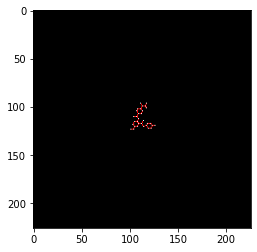

In [10]:
plt.show(print(v.shape))
plt.imshow(v)

We can make bigger molecules by reducing the embedding size. ***But beware that will also reduce the total image size***.

In [11]:
larger_img = vectorize(mols["mol"][0],embed=16, res=0.5).T.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(66, 66, 3)


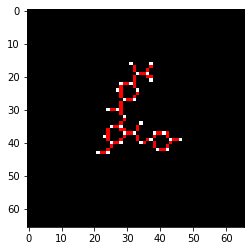

In [12]:
plt.show(print((larger_img.shape)))
plt.imshow(larger_img)

In [14]:
mols["molimage"] = mols["mol"].apply(partial(vectorize, embed=32, res=0.25))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


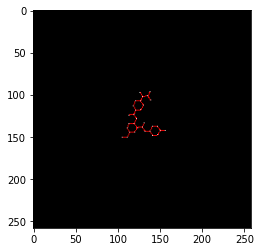

In [15]:
plt.imshow(mols["molimage"][0].T.numpy())

# Training our model

Now that we know how to convert the molecules to the desired format, we are ready to train a model using fastai! In order to do that, we need to define **three things**

## 1) **How to split data**

First, let's define how to split our data into training and validation sets. Luckly, our dataset comes with a column called "is_valid" showing which molecules should be used for validation and training. Therefore, we will use the ```ColSplitter``` class from fastai to get the indeces. We could also do a random split here or any kind at all. Fastai is very flexible!

In [16]:
splits = ColSplitter('is_valid')(mols)
splits

((#1703) [0,1,2,3,4,5,6,7,8,9...],
 (#426) [1703,1704,1705,1706,1707,1708,1709,1710,1711,1712...])

## 2) Define how to get the items

We need to tell fastai how to get the items that we'll feed to our model. In this case, we will use the images we created and stored in the "molimage" column of our dataframe.

In [17]:
x_tfms = ColReader('molimage')

## 3) Define the targets

Now we need to tell fastai where are our targets. In this case, our targets are in the column "act", showing the bioactivity of each molecule. We will also tell fastai to treat the values of this column as categories, which will be used to train a classification model.

In [18]:
y_tfms = [ColReader('act'),Categorize]

> The fastai book uses the DataBlock functionality to create the dataloaders at Chapter 2 and Jeremy says that we actually need **four things** 


> 1. What kind of data to work with;
> 2. How to get the items;
> 3. How to label these items;
> 4. How to create a validation set.


> But since we are using a custom data type, we'll skip the step defining the kind of data.

## **Create dataset**

Now we can create our dataset:

In [19]:
mol_dataset = Datasets(mols,[x_tfms,y_tfms], splits=splits)

In [20]:
x,y = mol_dataset[0]

In [21]:
x.shape,y

(torch.Size([3, 258, 258]), TensorCategory(0))

## **Create dataloaders**

In [22]:
dls = mol_dataset.dataloaders(batch_size=8)

Let's inspect one batch to see if everything is already:

In [23]:
x,y = dls.one_batch()

#collapse-output

x,y

It seems everything is in order

Alright! Let's train this beast!

## Fit

In [25]:
metrics = [Recall(pos_label=1),Recall(pos_label = 0), Precision(pos_label = 0), MatthewsCorrCoef()]

In [26]:
learn = cnn_learner(dls, resnet18, metrics=metrics,ps=0.25)

In [27]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,recall_score,recall_score,precision_score,matthews_corrcoef,time
0,1.012225,0.891549,0.318182,0.779412,0.668770,0.107454,00:19


epoch,train_loss,valid_loss,recall_score,recall_score,precision_score,matthews_corrcoef,time
0,0.685600,0.648243,0.636364,0.672794,0.765690,0.299299,00:23
1,0.686158,0.780590,0.376623,0.816176,0.698113,0.212925,00:22
2,0.648935,0.657959,0.422078,0.783088,0.705298,0.216988,00:23
3,0.590302,0.596761,0.603896,0.731618,0.765385,0.330533,00:23
4,0.476980,0.574860,0.616883,0.808824,0.788530,0.430224,00:23
5,0.416675,0.646075,0.779221,0.647059,0.838095,0.409640,00:23
6,0.345881,0.618086,0.538961,0.819853,0.758503,0.372781,00:23
7,0.210627,0.618316,0.467532,0.863971,0.741325,0.364997,00:23
8,0.175476,0.648488,0.525974,0.875000,0.765273,0.433942,00:23
9,0.157904,0.632916,0.538961,0.856618,0.766447,0.420398,00:23


It seems everything went pretty well! In addition, the Matthew's correlation coefficient is quite decent (~0.37).

# Interpretation

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

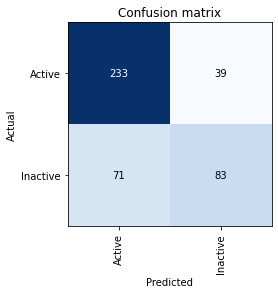

In [29]:
interp.plot_confusion_matrix()

The performance is pretty decent, if without any kind of data augmentation and hyperparameter optimization.

## Let's try with a little bit of data augmentation.

In the original paper, the authors used random rotations of the images. Why is that? Well, since most of the image is empty space, if we distort it even a little bit, by cropping or squishing, it might completly change the molecule represented. Rotating the image is a solution to the data augmentation problem because in this particular case it won't change the meaning of our images.

In [30]:
dls = mol_dataset.dataloaders(batch_size=8,after_batch=Rotate(max_deg=180))

In [31]:
x,y = dls.one_batch()

In [32]:
x

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [33]:
learn = cnn_learner(dls, resnet18, metrics=metrics,ps=0.25)

In [34]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,recall_score,recall_score,precision_score,matthews_corrcoef,time
0,1.077978,0.989249,0.357143,0.709559,0.660959,0.069014,00:17


epoch,train_loss,valid_loss,recall_score,recall_score,precision_score,matthews_corrcoef,time
0,0.734140,0.671884,0.344156,0.849265,0.695783,0.224086,00:23
1,0.685288,0.678868,0.357143,0.841912,0.698171,0.227231,00:23
2,0.669334,0.682344,0.506494,0.654412,0.700787,0.157556,00:23
3,0.595246,0.595930,0.409091,0.838235,0.714734,0.273986,00:26
4,0.505893,0.558520,0.467532,0.830882,0.733766,0.320368,00:30
5,0.440193,0.619289,0.623377,0.775735,0.784387,0.397478,00:30
6,0.352228,0.639708,0.551948,0.801471,0.759582,0.362148,00:30
7,0.246773,0.700151,0.545455,0.827206,0.762712,0.387982,00:30
8,0.178448,0.687083,0.558442,0.838235,0.770270,0.413870,00:30
9,0.171418,0.690827,0.629870,0.768382,0.785714,0.395096,00:30


In [35]:
interp = ClassificationInterpretation.from_learner(learn)

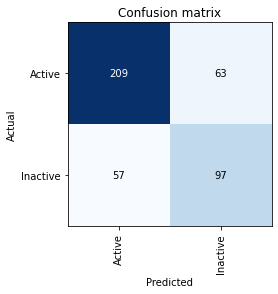

In [36]:
interp.plot_confusion_matrix()

It's a little bit better now :)

# Exporting the model

Now that we trained the model, we can export it and use it for inference.

In [37]:
learn.export()

In [38]:
learn_inf = load_learner('export.pkl')

In [39]:
learn_inf.predict(mols['molimage'][2])

('Inactive', tensor(1), tensor([0.0030, 0.9970]))

# Fin